In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

In [16]:
data = {
    'comment_text': ["Toxic comment"] * 10 + ["Clean comment"] * 90,
    'toxic': [1] * 10 + [0] * 90,
    'severe_toxic': [1] * 5 + [0] * 95,
    'obscene': [1] * 3 + [0] * 97,
    'threat': [1] * 2 + [0] * 98,
    'insult': [1] * 3 + [0] * 97,
    'identity_hate': [1] * 5 + [0] * 95
}
df = pd.DataFrame(data)

# Define a function to split and combine datasets
def split_and_combine(df, label_column, train_ratio=0.8):
    # Separate positive and negative cases
    pos_df = df[df[label_column] == 1]
    neg_df = df[df[label_column] == 0]
    
    # Split positive cases
    pos_train_df, pos_val_df = train_test_split(pos_df, test_size=1-train_ratio, stratify=pos_df[label_column])
    
    # Split negative cases
    neg_train_df, neg_val_df = train_test_split(neg_df, test_size=1-train_ratio, stratify=neg_df[label_column])
    
    # Combine the datasets
    train_df = pd.concat([pos_train_df, neg_train_df])
    val_df = pd.concat([pos_val_df, neg_val_df])
    
    # Shuffle the combined datasets
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    val_df = val_df.sample(frac=1).reset_index(drop=True)
    
    return train_df, val_df

# Split datasets for each label
train_df, val_df = df.copy(), df.copy()  # Start with the full dataset
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    train_df, val_df = split_and_combine(df, label)

# # Convert to lists
# texts_train = train_df['comment_text'].tolist()
# labels_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
# texts_val = val_df['comment_text'].tolist()
# labels_val = val_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values


In [18]:
train_df.sum()

comment_text     Clean commentClean commentToxic commentClean c...
toxic                                                            9
severe_toxic                                                     4
obscene                                                          3
threat                                                           2
insult                                                           3
identity_hate                                                    4
dtype: object

In [19]:
val_df.sum()

comment_text     Clean commentClean commentClean commentClean c...
toxic                                                            1
severe_toxic                                                     1
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    1
dtype: object

In [6]:

# Example DataFrame (replace this with your actual DataFrame)
data = {
    'comment_text': ["Toxic comment"] * 10 + ["Clean comment"] * 90,
    'toxic': [1] * 10 + [0] * 90,
    'severe_toxic': [1] * 5 + [0] * 95,
    'obscene': [1] * 3 + [0] * 97,
    'threat': [1] * 2 + [0] * 98,
    'insult': [1] * 3 + [0] * 97,
    'identity_hate': [1] * 5 + [0] * 95
}
df = pd.DataFrame(data)

# Separate toxic samples and non-toxic samples
toxic_df = df[df['toxic'] == 1]
non_toxic_df = df[df['toxic'] == 0]

# Calculate sizes
toxic_train_size = int(0.1 * len(df))  # 10% of the whole dataset
non_toxic_train_size = int(0.9 * len(df))  # The rest for non-toxic

# Split toxic and non-toxic data into training and validation sets
toxic_train_df, toxic_val_df = train_test_split(toxic_df, test_size=0.2, stratify=toxic_df['toxic'])
non_toxic_train_df, non_toxic_val_df = train_test_split(non_toxic_df, test_size=0.2, stratify=non_toxic_df['toxic'])

# Combine the data
train_df = pd.concat([toxic_train_df, non_toxic_train_df])
val_df = pd.concat([toxic_val_df, non_toxic_val_df])

# Shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

# Convert to lists
texts_train = train_df['comment_text'].tolist()
labels_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
texts_val = val_df['comment_text'].tolist()
labels_val = val_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Define the dataset class
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)

# Prepare datasets
train_dataset = ToxicCommentDataset(texts_train, labels_train, tokenizer, max_len=128)
val_dataset = ToxicCommentDataset(texts_val, labels_val, tokenizer, max_len=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_total_limit=2
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset  # Provide the eval_dataset here
)

# Train the model
trainer.train()


c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be remo

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_20984\2154201256.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}


{'loss': 0.6928, 'grad_norm': 1.4815338850021362, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6879714131355286, 'eval_runtime': 0.133, 'eval_samples_per_second': 150.344, 'eval_steps_per_second': 22.552, 'epoch': 1.0}
{'loss': 0.6833, 'grad_norm': 1.7670224905014038, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6771639585494995, 'eval_runtime': 0.131, 'eval_samples_per_second': 152.638, 'eval_steps_per_second': 22.896, 'epoch': 2.0}
{'loss': 0.6692, 'grad_norm': 1.9891972541809082, 'learning_rate': 3e-06, 'epoch': 3.0}


C:\Users\User\AppData\Local\Temp\ipykernel_20984\2154201256.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6555161476135254, 'eval_runtime': 0.135, 'eval_samples_per_second': 148.115, 'eval_steps_per_second': 22.217, 'epoch': 3.0}
{'train_runtime': 8.7732, 'train_samples_per_second': 27.356, 'train_steps_per_second': 3.42, 'train_loss': 0.6817727247873943, 'epoch': 3.0}


TrainOutput(global_step=30, training_loss=0.6817727247873943, metrics={'train_runtime': 8.7732, 'train_samples_per_second': 27.356, 'train_steps_per_second': 3.42, 'total_flos': 15787230289920.0, 'train_loss': 0.6817727247873943, 'epoch': 3.0})

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments


# Example DataFrame (replace this with your actual DataFrame)
data = {
    'comment_text': ["This is a toxic comment", "This is a clean comment"],
    'toxic': [1, 0],
    'severe_toxic': [0, 0],
    'obscene': [0, 0],
    'threat': [0, 0],
    'insult': [0, 0],
    'identity_hate': [0, 0]
}
df = pd.DataFrame(data)

# Split the features and labels
texts = df['comment_text'].tolist()
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Define the dataset class
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)

dataset = ToxicCommentDataset(texts, labels, tokenizer, max_len=128)
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # Evaluate every epoch (updated argument)
    save_strategy="epoch"            # Save checkpoint every epoch
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=eval_dataset
)

# Train the model
trainer.train()


c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_20984\3019409088.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.675223708152771, 'eval_runtime': 0.0845, 'eval_samples_per_second': 11.839, 'eval_steps_per_second': 11.839, 'epoch': 1.0}


C:\Users\User\AppData\Local\Temp\ipykernel_20984\3019409088.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6751617193222046, 'eval_runtime': 0.067, 'eval_samples_per_second': 14.922, 'eval_steps_per_second': 14.922, 'epoch': 2.0}


C:\Users\User\AppData\Local\Temp\ipykernel_20984\3019409088.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}
C:\Users\User\AppData\Local\Temp\ipykernel_20984\3019409088.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val.squeeze()) for key, val in encoding.items()}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6750385165214539, 'eval_runtime': 0.019, 'eval_samples_per_second': 52.62, 'eval_steps_per_second': 52.62, 'epoch': 3.0}
{'train_runtime': 8.4746, 'train_samples_per_second': 0.708, 'train_steps_per_second': 0.354, 'train_loss': 0.6808248360951742, 'epoch': 3.0}


TrainOutput(global_step=3, training_loss=0.6808248360951742, metrics={'train_runtime': 8.4746, 'train_samples_per_second': 0.708, 'train_steps_per_second': 0.354, 'total_flos': 394680757248.0, 'train_loss': 0.6808248360951742, 'epoch': 3.0})

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import layers
# from tensorflow.keras.layers import TextVectorization
# import tensorflow as tf

from pathlib import Path 

import os

import torch
import torch.optim as optim


# transformers
# from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
# from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig


pd.plotting.register_matplotlib_converters()
%matplotlib inline


%load_ext autoreload
%autoreload 2
from help_tool import help_tool

# Setting graph parameters
sns.set_theme(style='white')

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
clean_data = help_tool.csv_download(
    r'Archive\clean_data.csv').drop(columns='Unnamed: 0')

In [14]:
clean_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly stuck thanks talk utc,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later noone else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipediagoodarticlenominationstransport,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
141935,ffe987279560d7ff,second time asking view completely contradicts coverage reliable sources anyone care feel cant even give consistent argument opening supposed mention significant aspects significant ones,0,0,0,0,0,0
141936,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
141937,ffee36eab5c267c9,spitzer umm theres actual article prostitution ring crunch captain,0,0,0,0,0,0
141938,fff125370e4aaaf3,looks like actually put speedy first version deleted look,0,0,0,0,0,0


In [12]:
from pathlib import Path 

import os

import torch
import torch.optim as optim


# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [16]:
labels = clean_data.drop(columns=['id', 'comment_text']).columns
X = clean_data.drop(columns=labels)

In [17]:
clean_data[labels].sum()

toxic            14210
severe_toxic      1413
obscene           7853
threat             440
insult            7383
identity_hate     1290
dtype: int64

In [18]:
print(f'Training set: {clean_data.shape}, {clean_data.shape}')

Training set: (141940, 8), (141940, 8)


In [19]:
# Convert labels to binary format using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(clean_data[labels].values)

# Split data into train, validate, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.4, random_state=42, stratify=y_binary)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the shape of the splits
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (85164, 2), (85164, 2)
Validation set: (28388, 2), (28388, 2)
Test set: (28388, 2), (28388, 2)


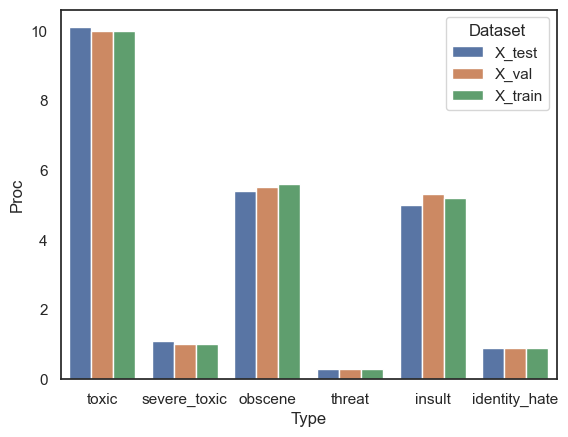

In [20]:
sns.barplot(data=help_tool.model_dataset_distribution(clean_data, X_train, X_val, X_test), hue='Dataset', y='Proc', x='Type')
plt.show()

Actual dataset

In [21]:
X_train.drop(columns=('id'), inplace=True)
X_val.drop(columns=('id'), inplace=True)
X_test.drop(columns=('id'), inplace=True)

In [22]:
# train = help_tool.csv_download(
#     r'Archive\train.csv')

In [23]:
# X_val = train[train['id'].isin(X_val['id'])]['comment_text']
# X_val.shape

In [24]:
# X_test = train[train['id'].isin(X_test['id'])]['comment_text']
# X_test.shape

In [25]:
# labels = clean_data.drop(columns=['id', 'comment_text']).columns

# # Convert labels to one-hot encoding
# y = clean_data[labels].values
#y = to_categorical(clean_data[labels].values)

In [26]:
y_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

# Tokenizer

In [27]:
# If X_train is a pandas Series or DataFrame column, convert it to a list
X_train = X_train['comment_text'].tolist()


In [28]:
print(type(X_train))  # Should be list
print(type(X_train[0]))  # Should be str
print(X_train[:3])  # Check the first few elements


<class 'list'>
<class 'str'>
['one opinion says born cuba position says information right want balance say find balance arguing skipping information write wikipage humanist tolerant respect opinions others totally alone opinion book indicates born cuba sources weak way aruge act makes suspicious emotional personal interest attacking de zayas please leave personal conflicts outside wiki thanks mp', 'comment bad faith nomination truly believe nonnotable artists nonnotable band dont meet single point set forth wpmusic reference verified feel free add ill publicly change opinion additionally pages created bands webmaster', 'redirect talkgdels incompleteness theoremsarchive']


In [18]:
# encoded_inputs = tokenizer(X_train, 
#                            padding=True, 
#                            truncation=True, 
#                            max_length=76, 
#                            return_tensors='pt',  # Return PyTorch tensors
#                            return_attention_mask=True)

# # Extract the token IDs and attention masks
# input_ids = encoded_inputs['input_ids']
# attention_masks = encoded_inputs['attention_mask']

# print("Token IDs:", input_ids)
# print("Attention Masks:", attention_masks)


In [29]:
import torch
from torch.utils.data import TensorDataset


ModuleNotFoundError: No module named 'torch'

In [ ]:
labels_tensor = torch.tensor(y_train)

In [ ]:
labels_tensor

tensor([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.int32)

In [ ]:
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels_tensor)

In [ ]:
dataset

Steps to Adapt a Transformer Model for Sequence Classification

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning message you're seeing is normal when you load a pre-trained model like RoBERTa and adapt it for a specific downstream task, such as sequence classification. This happens because the classification head (the part of the model that makes predictions) is not pre-trained—it needs to be initialized and trained on your specific task.

In [ ]:
encoded_inputs = tokenizer(X_train, 
                           padding=True, 
                           truncation=True, 
                           max_length=76, 
                           return_tensors='pt',  # Return PyTorch tensors
                           return_attention_mask=True)

# Extract the token IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [ ]:
# Convert labels to tensor
labels_tensor = torch.tensor(y_train)

# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels_tensor)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # Evaluate every epoch (updated argument)
    save_strategy="epoch"            # Save checkpoint every epoch
)


In [ ]:
trainer = Trainer(
    model=model,                         # The pre-trained model with new head
    args=training_args,                  # Training arguments
    train_dataset=dataset,               # The training dataset
    # You can add eval_dataset here if you have validation data
)


In [ ]:
trainer.train()


[autoreload of transformers.utils.import_utils failed: Traceback (most recent call last):
  File "c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\IPython\extensions\autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\IPython\extensions\autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\IPython\extensions\autoreload.py

: 

In [ ]:
results = trainer.evaluate()
print(results)


In [13]:
# # Combine all the necessary text processing functions into a single function
# def process_text(text):
#     # Define the regex pattern to remove dates and IP addresses
#     combined_pattern = (
#         r'\b(?:\d{1,2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31, 19 July 2006"
#         r'\d{1,2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 19 July 2006"
#         r'\d{1,2} [A-Za-z]{3,10}, \d{4}|'  # "31 July, 2006"
#         r'\d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 July 2006"
#         r'\d{1,2}, [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31, July 2006, 18:47"
#         r'\d{1,2} [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31 July 2006, 18:47"
#         r'\d{1,2} [A-Za-z]{3,10} \d{4} \d{1,2}:\d{2}|'  # "31 July 2006 18:47"
#         r'\d{1,2}:\d{2}, [A-Za-z]{3,10} \d{1,2}, \d{4}|'  # "18:47, July 31, 2006"
#         r'\d{1,2}:\d{2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47, 31 July 2006"
#         r'\d{1,2}:\d{2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47 31 July 2006"
#         r'\d{1,2} [A-Za-z]{3,10} \d{1,2}:\d{2}|'  # "26 July 17:03 UTC"
#         r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'  # IP address
#         r')\b'
#     )

#     # Remove dates and IP addresses
#     text = re.sub(combined_pattern, '', text)

#     # Replace specific prefixes
#     text = re.sub(r'Wikipedia:|WP:|Category:|disambiguation|otheruses', '', text)

#     # Replace filenames (implement your function or use a placeholder here)
#     text = help_tool.replace_filenames(text)

#     # Clean the text (implement your function or use a placeholder here)
#     text = help_tool.clean_text(text)

#     # Remove stopwords (implement your function or use a placeholder here)
#     text = help_tool.remove_stopwords(text)

#     # Remove non-ASCII characters (implement your function or use a placeholder here)
#     text = help_tool.remove_non_ascii(text)

#     return text.strip()

# # Apply the combined text processing function
# clean_data['comment_text'] = clean_data['comment_text'].apply(process_text)

# # Remove empty strings and duplicates
# clean_data = clean_data[clean_data['comment_text'] != '']
# clean_data = clean_data.drop_duplicates()

# # Filter out rows containing 'Navbox'
# clean_data = clean_data[~clean_data['comment_text'].str.contains("Navbox")]

In [14]:
# train['comment_text'] = train['comment_text'].apply(help_tool.replace_url_with_domain)

# combined_pattern = (
#     r'\b(?:\d{1,2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31, 19 July 2006"
#     r'\d{1,2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 19 July 2006"
#     r'\d{1,2} [A-Za-z]{3,10}, \d{4}|'  # "31 July, 2006"
#     r'\d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 July 2006"
#     r'\d{1,2}, [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31, July 2006, 18:47"
#     r'\d{1,2} [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31 July 2006, 18:47"
#     r'\d{1,2} [A-Za-z]{3,10} \d{4} \d{1,2}:\d{2}|'  # "31 July 2006 18:47"
#     r'\d{1,2}:\d{2}, [A-Za-z]{3,10} \d{1,2}, \d{4}|'  # "18:47, July 31, 2006"
#     r'\d{1,2}:\d{2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47, 31 July 2006"
#     r'\d{1,2}:\d{2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47 31 July 2006"
#     r'\d{1,2} [A-Za-z]{3,10} \d{1,2}:\d{2}|'  # "26 July 17:03 UTC"
#     r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'  # IP address
#     r')\b'
# )


# # Remove the date pattern from the 'comment_text' column
# train['comment_text'] = train['comment_text'].str.replace(combined_pattern, '', regex=True).str.strip()

# train['comment_text'] = train['comment_text'].replace(
#     {'Wikipedia:': '', 'WP:': '', 'Category:': '', 'disambiguation': '', 'otheruses': ''
#      })

# train = train[~ train['comment_text'].str.contains("Navbox")]

# train['comment_text'] = train['comment_text'].apply(help_tool.replace_filenames)

# train['comment_text'] = train['comment_text'].apply(help_tool.clean_text)

# train['comment_text'] = train['comment_text'].apply(help_tool.remove_stopwords)

# train['comment_text'] = train['comment_text'].apply(help_tool.remove_non_ascii)

# train = train[train['comment_text'] != '']

# train = train[~train['comment_text'].duplicated()]

 Data Preparation
Dataset: Typically, the dataset for this task includes text comments labeled with multiple classes indicating different types of toxicity (e.g., toxic, severe_toxic, obscene, threat, insult, identity_hate).
Preprocessing: This includes tokenizing the text, padding sequences, and converting labels to a one-hot encoded format.

In [157]:
max_seqlen = 18
batch_size = 64
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

# Vecotorization

In [149]:
vocabulary = set()
X_train['comment_text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

111449


In [159]:
# Limit vocabulary size to a reasonable number, e.g., 10,000
max_vocabulary_size = 2000  # Adjust as needed

# Define the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocabulary_size, 
    ngrams=1,  # Use ngrams=1 for unigrams if still facing issues
    output_mode="tf_idf"
)

# Adapt the TextVectorization layer to the training data
text_vectorizer.adapt(X_train['comment_text'])

# Optional: Define a function to truncate sequences to the max length
def truncate_sequences(sequences, maxlen):
    return tf.strings.substr(sequences, 0, maxlen)

# Apply truncation before vectorization
truncated_texts = X_train['comment_text'].apply(lambda x: ' '.join(x.split()[:max_seqlen]))

# Transform the truncated comment texts into vectorized form
vectorized_texts = text_vectorizer(truncated_texts)

# If you need the result as a NumPy array
vectorized_texts_np = vectorized_texts.numpy()

# Display the vectorized output
print(vectorized_texts_np)

[[22.211061  0.        0.       ...  0.        0.        0.      ]
 [27.763826  0.        0.       ...  0.        0.        0.      ]
 [16.658297  0.        0.       ...  0.        0.        0.      ]
 ...
 [16.658297  0.        0.       ...  0.        0.        0.      ]
 [11.105531  0.        0.       ...  0.        0.        0.      ]
 [16.658297  0.        0.       ...  0.        0.        0.      ]]


In [165]:
# Tokenization
tokenizer = Tokenizer(num_words=20000)  # use the top 20,000 words
tokenizer.fit_on_texts(X_train['comment_text'])

# Convert texts to sequences
X = tokenizer.texts_to_sequences(X_train['comment_text'])
X = pad_sequences(X, maxlen=76)  # pad to a max length of 100 words

In [166]:
X

array([[   0,    0,    0, ...,  145,   16, 4788],
       [   0,    0,    0, ...,  205, 1504, 8066],
       [   0,    0,    0, ...,    0,    0,  186],
       ...,
       [   0,    0,    0, ...,    7, 1045,  614],
       [   0,    0,    0, ..., 1980,   67, 5289],
       [   0,    0,    0, ...,  616,  676,  331]])

In [ ]:
# Convert labels to one-hot encoding
y = clean_data[labels].values
y = to_categorical(y)


In [179]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow import keras

In [168]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='sigmoid')  # 5 output neurons for 5 classes
])

c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [169]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[AUC(name='auc')])

In [172]:
X_train.shape

(85164, 1)

In [173]:
y_train.shape

(85164, 2)

In [176]:
model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 5)

Model Creation
You can use an embedding layer followed by a series of LSTM, GRU, or CNN layers, with a final dense layer using a softmax activation function to output probabilities for each class.

Training the Model
The model is trained on the prepared data, typically with a validation split to monitor the performance on unseen data.

In [182]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

In [183]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [184]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    X_train, y_train, X_val, y_val, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

NameError: name 'lookup' is not defined

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_val, y_val))


Evaluation
After training, evaluate the model on the test data to determine its accuracy, precision, recall, F1-score, etc.

In [ ]:
# Evaluate on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# To get more detailed evaluation metrics like precision, recall, and F1-score:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)
y_val_classes = y_val.argmax(axis=-1)

print(classification_report(y_val_classes, y_pred_classes, target_names=labels))


Fine-tuning and Optimization
You might want to fine-tune the model by adjusting hyperparameters like the learning rate, batch size, or network architecture.
Consider techniques like dropout, regularization, and batch normalization to avoid overfitting.

Saving and Loading the Model
Once the model is trained, you can save it for future use.

In [ ]:
# Save the model
model.save('toxic_comment_model.h5')

# Load the model
from tensorflow.keras.models import load_model
model = load_model('toxic_comment_model.h5')


Prediction on New Data
To make predictions on new comments, preprocess them in the same way as the training data and then use the trained model to predict.

In [ ]:
new_comments = ["This is an example comment.", "Another comment that could be toxic."]
new_sequences = tokenizer.texts_to_sequences(new_comments)
new_padded = pad_sequences(new_sequences, maxlen=100)

predictions = model.predict(new_padded)
